In [44]:
# -*- coding:uft-8
from  skimage import io,transform
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import time
import glob
import cv2
import os

### 1、 please read the flower photoes  and add them to a list.

In [21]:
width, height, channels = 100, 100, 3
path_imgs = './flower_photos/'
cat_imgs = [path_imgs+x for x in os.listdir(path_imgs) if os.path.isdir(path_imgs+x)]

images = []
labels = []

for num_cat, category in enumerate(cat_imgs):
    for img in glob.glob(category + '/*.jpg'):
        image = io.imread(img)
        image = transform.resize(image, (width, height))
        images.append(image)
        labels.append(num_cat)

plt.imshow(images[1])

###  2、View the length of the previous generation list, take the last 11 elements to a new list.

In [25]:
len(images)

3670

In [26]:
last11 = images[-11:]
last_labels11 = labels[-11:]

### 3、Use skimage to read the nine images in the previous list, and unify the image size to (100,100,3), then save the data to an array.

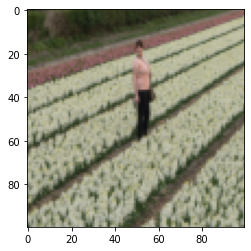

In [81]:
plt.imshow(last11[0])

In [98]:
reduced_images = []

for img in last11:
    image = transform.resize(img, (100, 100))
    reduced_images.append(image)

reduced_images = np.array(reduced_images, dtype='float')

In [101]:
plt.imshow(reduced_images[1])

### 4、Try to build a simply CNN and use it to train our flower photoes

### Create model

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, Activation, Flatten, Dropout
from tensorflow.keras import backend as K

In [2]:
height, weight, depth = 96, 96, 3
classes = 5
chanDim = -1
input_shape = (height, weight, depth)
epochs = 100
lr = 1e-3
BS = 32

In [3]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding="same", activation='relu'))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same", activation='relu'))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(classes, activation='softmax'))

### Preparing Dataset

In [25]:
import matplotlib
matplotlib.use("Agg")

from tensorflow.keras.preprocessing.image import img_to_array, ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
from imutils import paths
import numpy as np
import random
import pickle
import cv2
import os

In [11]:
data = []
labels = []
dataset = 'flower_photos'

imagePaths = sorted(list(paths.list_images(dataset)))
random.seed(42)
random.shuffle(imagePaths)

In [12]:
imagePaths[:1]

['flower_photos\\tulips\\2785458179_9130812eef_m.jpg']

In [13]:
for imagePath in imagePaths:
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (input_shape[0], input_shape[1]))
    image = img_to_array(image)
    data.append(image)
    
    label = imagePath.split(os.path.sep)[-2]
    labels.append(label)

### Normalize images data

In [14]:
data = np.array(data, dtype='float') / 255.0
labels = np.array(labels)
print("[INFO] data matrix: {:.2f}MB".format(data.nbytes / (1024 * 1000.0)))

lb = LabelBinarizer()
labels = lb.fit_transform(labels)

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

[INFO] data matrix: 792.72MB


In [15]:
labels[:2]

array([[0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0]])

### Augmentation

In [16]:
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.2,
                         zoom_range=0.2, horizontal_flip=True, fill_mode="nearest")

## Train the model

In [17]:
optimizer = Adam(decay=lr/epochs)
model.compile(loss='categorical_crossentropy', optimizer = optimizer, metrics=['accuracy'])

In [19]:
H = model.fit(x=aug.flow(X_train, y_train, batch_size=BS),
              validation_data=(X_test, y_test),
              steps_per_epoch=len(X_train) // BS,
              epochs=epochs, verbose=1)

  ...
    to  
  ['...']
Train for 91 steps, validate on 734 samples
Epoch 1/100
91/91 [==============================] - 62s 686ms/step - loss: 1.9324 - accuracy: 0.4346 - val_loss: 2.9727 - val_accuracy: 0.2575
Epoch 2/100
91/91 [==============================] - 61s 667ms/step - loss: 1.3887 - accuracy: 0.5234 - val_loss: 3.8593 - val_accuracy: 0.2575
Epoch 3/100
91/91 [==============================] - 61s 669ms/step - loss: 1.2593 - accuracy: 0.5517 - val_loss: 2.7357 - val_accuracy: 0.2984
Epoch 4/100
91/91 [==============================] - 61s 669ms/step - loss: 1.1734 - accuracy: 0.5885 - val_loss: 2.4710 - val_accuracy: 0.3569
Epoch 5/100
91/91 [==============================] - 62s 679ms/step - loss: 1.0374 - accuracy: 0.6147 - val_loss: 1.4743 - val_accuracy: 0.5041
Epoch 6/100
91/91 [==============================] - 61s 672ms/step - loss: 0.9962 - accuracy: 0.6484 - val_loss: 1.1355 - val_accuracy: 0.6035
Epoch 7/100
91/91 [==============================] - 62s 686ms/step

Epoch 57/100
91/91 [==============================] - 58s 642ms/step - loss: 0.2505 - accuracy: 0.9081 - val_loss: 0.6919 - val_accuracy: 0.8106
Epoch 58/100
91/91 [==============================] - 59s 645ms/step - loss: 0.3110 - accuracy: 0.8788 - val_loss: 0.9080 - val_accuracy: 0.7616
Epoch 59/100
91/91 [==============================] - 59s 643ms/step - loss: 0.2779 - accuracy: 0.8953 - val_loss: 0.7540 - val_accuracy: 0.8065
Epoch 60/100
91/91 [==============================] - 58s 642ms/step - loss: 0.2250 - accuracy: 0.9122 - val_loss: 0.7188 - val_accuracy: 0.7916
Epoch 61/100
91/91 [==============================] - 58s 642ms/step - loss: 0.2045 - accuracy: 0.9205 - val_loss: 0.6863 - val_accuracy: 0.8025
Epoch 62/100
91/91 [==============================] - 58s 642ms/step - loss: 0.2325 - accuracy: 0.9108 - val_loss: 0.7206 - val_accuracy: 0.8106
Epoch 63/100
91/91 [==============================] - 58s 642ms/step - loss: 0.2015 - accuracy: 0.9222 - val_loss: 0.9944 - val_ac

## Evaluating model

In [26]:
print("[INFO] evaluating network...")
predictions = model.predict(x=X_test, batch_size=32)
print(classification_report(y_test.argmax(axis=1),predictions.argmax(axis=1), target_names=lb.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

       daisy       0.78      0.81      0.80       106
   dandelion       0.87      0.83      0.85       189
       roses       0.77      0.64      0.70       135
  sunflowers       0.79      0.92      0.85       146
      tulips       0.78      0.80      0.79       158

    accuracy                           0.80       734
   macro avg       0.80      0.80      0.80       734
weighted avg       0.80      0.80      0.80       734



## Save the model

In [21]:
model.save('flowers.model', save_format="h5")

f = open('lb.pickle', "wb")
f.write(pickle.dumps(lb))
f.close()

### Save plot

In [24]:
plt.style.use("ggplot")
plt.figure()
N = epochs
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")
plt.savefig('plot.png')

# Prediction

In [102]:
from tensorflow.keras.models import load_model
from imutils import paths
import imutils
import pickle
import cv2
import os

height, width = 96, 96

# Prepare paths of testing images
testPaths = sorted(list(paths.list_images('test_images')))
print(testPaths)

['test_images/daisys.jpg', 'test_images/dandelion.jpg', 'test_images/roses.jpg', 'test_images/sunflowers.jpg', 'test_images/tulips.jpg']


### Load models

In [2]:
model = load_model('flowers.model')
lb = pickle.loads(open('lb.pickle', "rb").read())

### Predict

In [17]:
for flower in testPaths:
    image = cv2.imread(flower)
    image = imutils.resize(image, width=600)
    output = image.copy()
    # Resize image to the model's size
    image = cv2.resize(image, (height, width))
    
    # Normalize the same way
    image = image.astype('float') / 255.0
    
    # Add the batch dimension
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    
    # Make prediction on the image
    preds = model.predict(image)
    i = preds.argmax(axis=1)[0]
    label = lb.classes_[i]
    
    # Draw the label predict
    answer = "{}: {:.2f}%".format(label, preds[0][i] * 100)
    true = flower.split(os.path.sep)[-1].split('.')[0]
    
    print("Predict {}: Network's answer is {}".format(true, answer))

Predict daisys: Network's answer is daisy: 100.00%
Predict dandelion: Network's answer is dandelion: 100.00%
Predict roses: Network's answer is roses: 100.00%
Predict sunflowers: Network's answer is sunflowers: 100.00%
Predict tulips: Network's answer is tulips: 99.96%
